In [1]:
import torch
# Set seed
torch.manual_seed(23)

In [2]:
from src.qwen import load_qwen
model_qwen, tokenizer = load_qwen()

/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


# Part 3 (a) (Continued..)

Plan of action:

- Preprocess the data, using `load_and_preprocess`, and split the data into `train_texts`, `val_texts` and `val_text_70` $\equiv$ 900, 100 and 100 (systems). 
- The two validation sets `val_texts` and `val_text_70` have the same `shape` but:
    - In `val_texts` each system has the full 100 pairs of prey and predators
    - In `val_texts_70` each system has only the first 70 pairs of prey and predators
- We train the model on tokenised `train_texts`
- We validated the model by predicting the remaining 30 pair points in each of the 100 system in tokenised `val_texts_70`. 
- We then compare the predicted results from `val_texts_70` to the gruond truth data `val_texts` (or `true_val_values` obtained with `data_scale_split`)
- Just like for the untrained models we then want to compute MSE and RMSE 
- And report the loss/perplexity of each trained models

We are recomended to train our model up to 10,000 steps, but we have a budgeted number of flops overall for training $10^{17}$ and due to computational power required, we are going to proceed with fewer steps first, also to familiarise with the traing procedure, before increasing the number of steps and using HPC.

In synthesis:

“We trained on 900 systems, validated on 100 full sequences for loss monitoring, and evaluated forecasting performance by generating future predictions given the first 70 steps from each validation sequence.”

All the above description has been fully prepared in `set_up_lora.py`. For flops estimation we can use `total_transformer_training_flops` in `flops.py`. The reader is invited to explore and analyse every file in `src`.

In [3]:
# Import designed functions
from src.set_up_lora import*
from src.flops import*

After training the model we can determine the estimate number of flops based on training steps and other metrics.

For this part we do not want to exceed 5000 steps, otherwise we will be too close to the limited number of FLOPs allowed for training

To train the model we are going to implement the function `train_lora_model` from `set_up_lora.py`.

In [4]:
model_lora0, loss_lora0, grad_norm_values0, loss_values0 = train_lora_model(model_qwen, tokenizer) # default steps and hyper parameters are set here

Training Progress Steps 0:   0%|          | 1/1142 [00:00<12:21,  1.54it/s]

[Step 0] Loss: 2.4747 | Grad norm: 2.0000


Training Progress Steps 1142:   0%|          | 1/1142 [00:00<04:46,  3.99it/s]

[Step 1142] Loss: 1.0362 | Grad norm: 0.6227


Training Progress Steps 2284:   0%|          | 1/1142 [00:00<04:38,  4.09it/s]

[Step 2284] Loss: 0.7665 | Grad norm: 0.8242


Training Progress Steps 3426:   0%|          | 1/1142 [00:00<04:43,  4.03it/s]

[Step 3426] Loss: 0.6842 | Grad norm: 0.9162


Training Progress Steps 4568:   0%|          | 1/1142 [00:00<04:45,  3.99it/s]

[Step 4568] Loss: 0.5223 | Grad norm: 1.2193


Training Progress Steps 4568:  38%|███▊      | 431/1142 [01:38<02:42,  4.37it/s]


In [5]:
config = model_lora0.config

# Parameters
num_steps = 5000
batch_size = 4
seq_len = 512
d_model = config.hidden_size
num_heads = config.num_attention_heads
num_layers = config.num_hidden_layers
intermediate_dim = 2 * d_model  # SwiGLU
lora_rank = 4  # if using LoRA

total_flops_estimate = total_transformer_training_flops(num_steps, batch_size, seq_len, num_layers, d_model, num_heads, intermediate_dim, lora_rank)

print(f'Total number of estimated FLOPs for training LoRA with {num_steps} steps:',total_flops_estimate)

Total number of estimated FLOPs for training LoRA with 5000 steps: 5983174656000000


Evaluating loss and perplexity of both tarin and validation set, there is a designed function in `set_up_lora.py`, that evaluates the perplexity and loss of the validation set, to determine the loss and perplexity of the training set, we can directly extract it from `model_lora_5000`.

### Loss and Perplexity 

In [6]:
_,val_texts, val_texts_70 = load_and_preprocess("data/lotka_volterra_data.h5")

max_steps = 5000 # CHANGE IF REQUIRED
print(f"After training with {max_steps} steps")
print(f"Training loss: {loss_lora0:.4f}")
perplexity_train = np.exp(loss_lora0)
print(f"Training perplexity: {perplexity_train:.4f}")

loss_val0, ppl_val0 = evaluate_loss_perplexity_val(model_lora0, tokenizer, val_texts, 4)
print('')
print(f'Validation loss: {loss_val0:.4f}')
print(f'Validation perplexity: {ppl_val0:.4f}')

After training with 5000 steps
Training loss: 0.8073
Training perplexity: 2.2419


Validating: 100%|██████████| 75/75 [00:08<00:00,  8.90it/s, avg_loss=0.6911]


Validation loss: 0.6911
Validation perplexity: 1.9960


Saving metrics

In [7]:
# collecting results
collecting_results = [[loss_lora0, perplexity_train, 
                       loss_val0, ppl_val0,
                      total_flops_estimate]
                      ]
columns = ["Training Loss", "Training Perplexity", "Validation Loss", "Validation Perplexity", "FLOPs"]

# Collecting results in pd.DataFrame

best_model_results_df = pd.DataFrame(collecting_results, columns=columns)
print("Metric results from best model:")
print("")
print(best_model_results_df)

# Save results

best_model_results_df.to_csv("experiment_results/trained_lora_3a_5000/best_model_trval_loss_ppl.csv")

Metric results from best model:

   Training Loss  Training Perplexity  Validation Loss  Validation Perplexity  \
0       0.807306              2.24186         0.691133               1.995977   

              FLOPs  
0  5983174656000000  


### Forecasting Missing Pair Values

After training the model, we can start using its predictive ability with the function `prediction_after_training` also defined in `set_up_lora.py`. 
Our goal is to predict the missing 30 pairpoints in `val_texts_70`, to then compare it to the full validation set, already pre-defined in the function `prediction_after_training`. Once we have both sets we can evaluate the following metrics, error difference within each system, MSE and RMSE.

In [8]:
predicted_encoded0 = prediction_after_training(model_lora0, tokenizer, val_texts_70)

Generating predictions:   0%|          | 0/100 [00:00<?, ?it/s]/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=T

### Evaluating Metrics

To evaluate the metric mentioned above, we are going to use the designed function, `decoder_and_metrics_evaluator`, this function will return, the predicted outputs both as string-like and time=series (both outputs will be used in other functions), the true values in the validation set, and all the relevant metrics, i.e. MSE, RMSE and error in each idividual system.

In [10]:
predictions_decoded0, predicted_output0, true_values0, MSE_values0, RMSE_values0, error_per_system0 = decoder_and_metrics_evaluator(predicted_encoded0, tokenizer)

Saving results.

In [11]:
np.savez("experiment_results/trained_lora_3a_5000/predictions_decoded_trained_lora_3a.npz", *predictions_decoded0)
MSE_loaded = np.save("experiment_results/trained_lora_3a_5000/MSE_values_3a.npy", np.array(MSE_values0))
np.save('experiment_results/trained_lora_3a_5000/RMSE_values_3a', RMSE_values0)
np.savez("experiment_results/trained_lora_3a_5000/error_per_system_5000.npz", *error_per_system0)

### Visualisation of results

There is a designed function that wraps all the functions defined in `plotting.py` into a single function, `collective_plots`

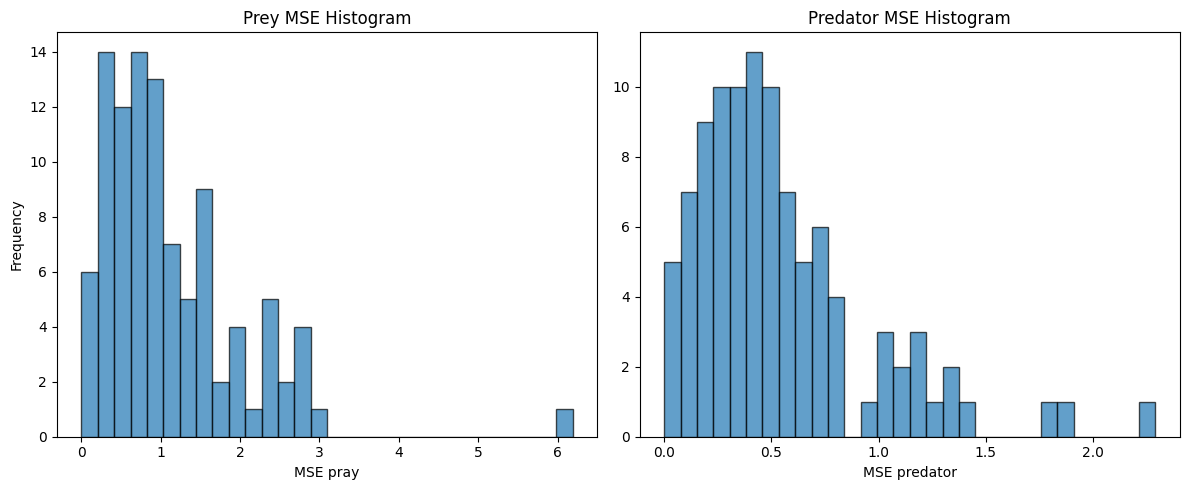

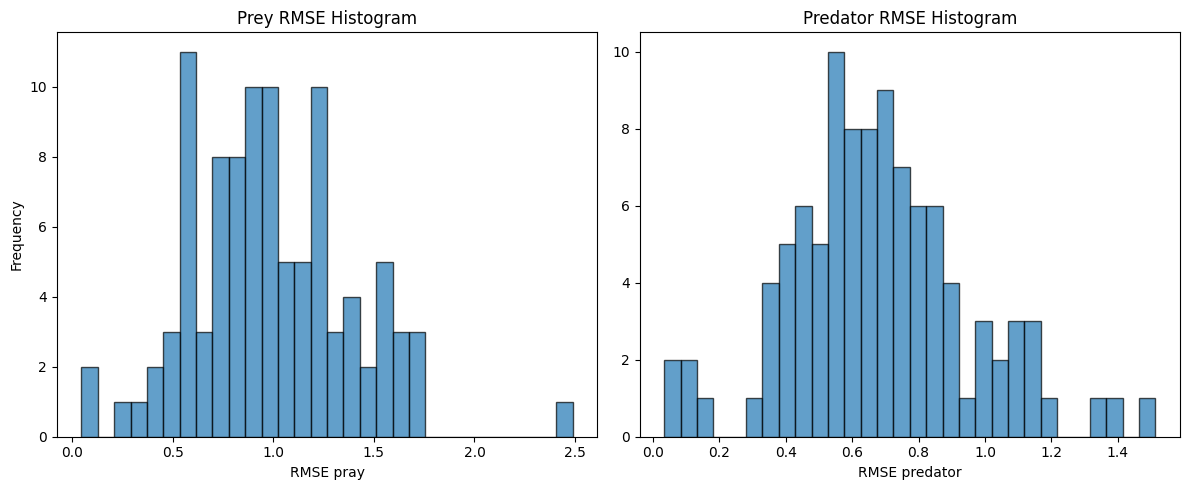

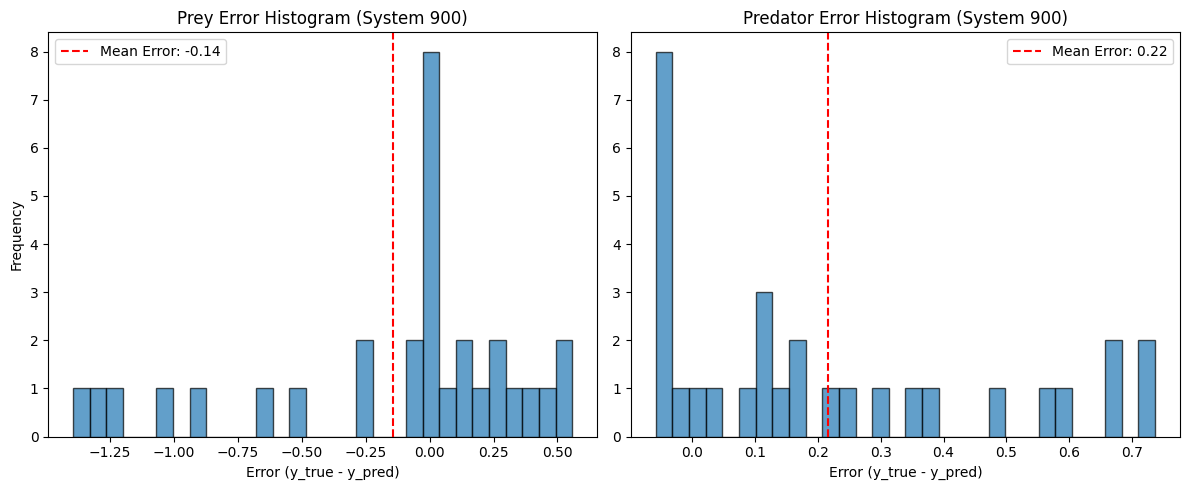

Decoded prediction shape: (103, 2)
True dataset shape: (30, 2)


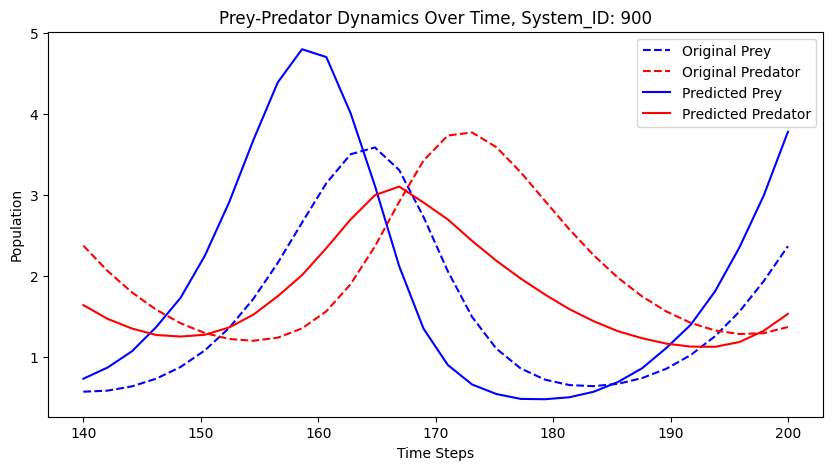

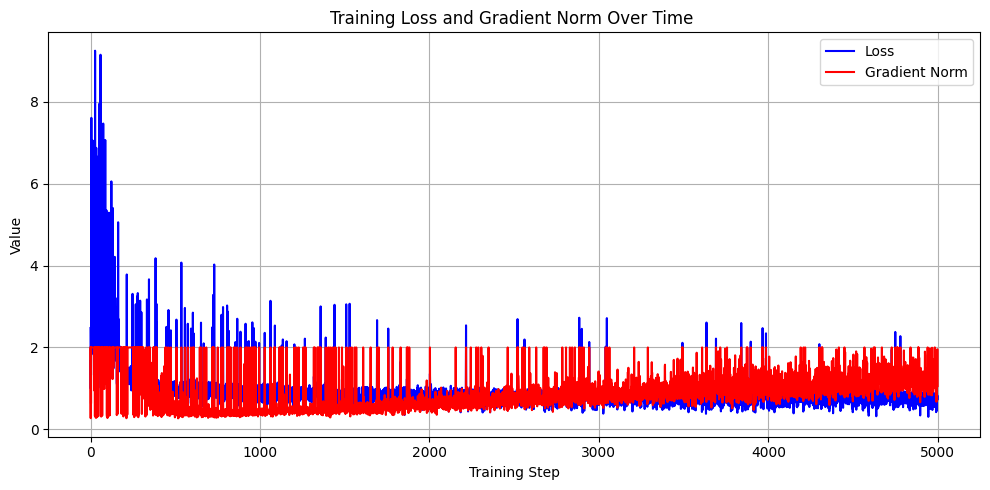

In [12]:
collective_plots(predicted_encoded0, tokenizer, system_id=0, bins=30)
grad_norm_loss_plot(loss_values0, grad_norm_values0) # printing loss and grad norm over training steps

# Part 3 (b)

# Hyper Parameter search

In this section we are aiming to find the a set of hyper parameters, in particular "rank, learning rate" and "context lenght".

In [1]:
import torch
# Set seed
torch.manual_seed(23)
torch.cuda.empty_cache() #Clean gpu memory for next experiment

In [2]:
import numpy as np
import torch
import torch.nn as nn
from src.set_up_lora import*
from src.preprocessor import*
from src.flops import*
import gc
import torch
from src.qwen import load_qwen
from src.set_up_lora import*
_, val_texts, _ = load_and_preprocess("data/lotka_volterra_data.h5")
import pandas as pd

/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


### Strategy:

We want to sweap through all possible combuination of the following values:
- $r = (2,4,8)$ "rank"
- $lr = (10^{-5}, 5 \times 10^{-5}, 10^{4})$ "learning rate"
- $cl = 512$ "context length", i.e. fixed for now

The nested loop below will be very expensive in terms of computation, this will load Qwen2.5 nine times, if your local machine struggles to reload Qwen2.5 that many times, use the alternative code below.

After sweaping through all possible combination, we want to use the combination that provided the smallest loss/perplexity value (both will be computed within the nested loop at each itearation). Same aplies for the next HP search.

In [3]:
_,tokenizer = load_qwen() # Load tokeniser


Training with r=2, lr=1e-05


Training Progress Steps 0:   0%|          | 1/1142 [00:00<11:06,  1.71it/s]

[Step 0] Loss: 2.3716 | Grad norm: 2.0000


Validating: 100%|██████████| 75/75 [00:08<00:00,  9.17it/s, avg_loss=0.8903]


-> Train Loss: 0.9629, Perplexity: 2.62
-> Validation Loss: 0.8903, Perplexity: 2.44
-> Estimated Flops: 1195577966592000


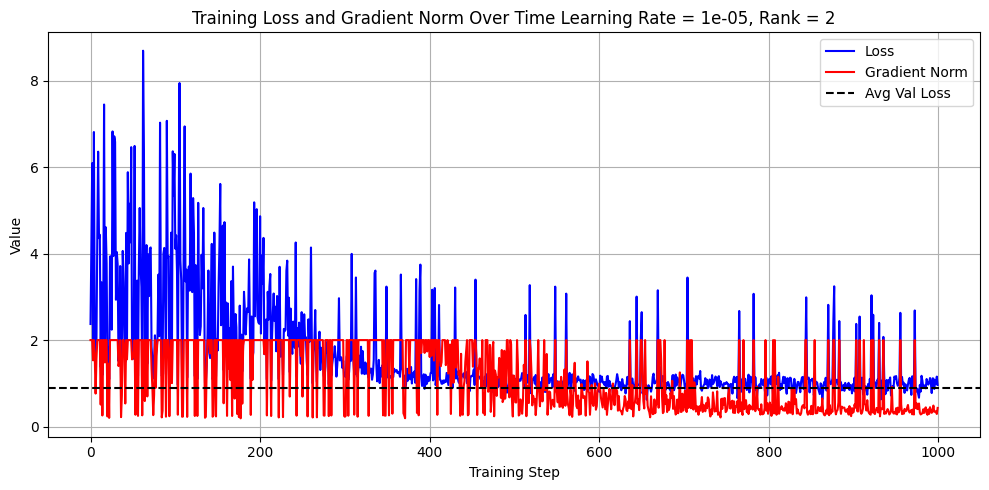


Training with r=2, lr=5e-05


Training Progress Steps 0:   0%|          | 1/1142 [00:00<09:17,  2.05it/s]

[Step 0] Loss: 6.5963 | Grad norm: 2.0000


Validating: 100%|██████████| 75/75 [00:08<00:00,  9.27it/s, avg_loss=0.7262]


-> Train Loss: 0.7952, Perplexity: 2.21
-> Validation Loss: 0.7262, Perplexity: 2.07
-> Estimated Flops: 1195577966592000


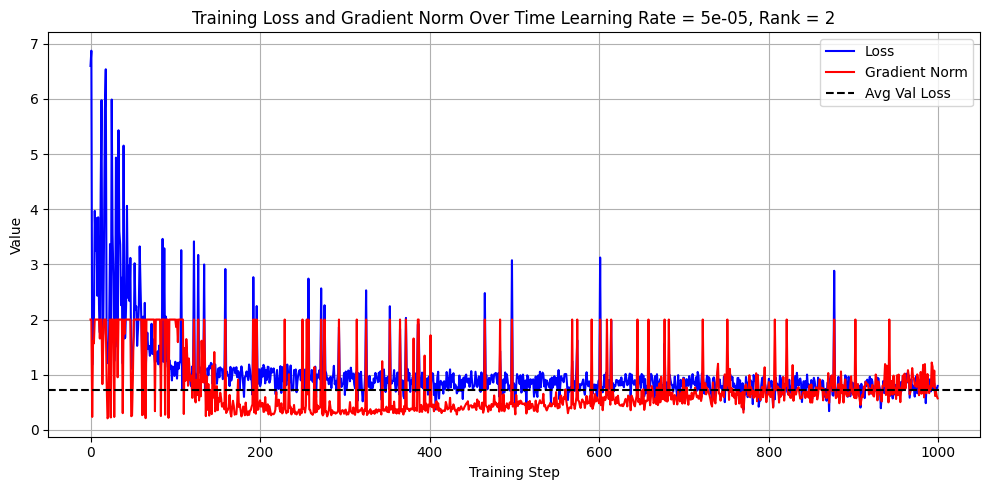


Training with r=2, lr=0.0001


Training Progress Steps 0:   0%|          | 1/1142 [00:00<09:18,  2.04it/s]

[Step 0] Loss: 4.0785 | Grad norm: 2.0000


Validating: 100%|██████████| 75/75 [00:08<00:00,  9.18it/s, avg_loss=0.6893]


-> Train Loss: 0.9012, Perplexity: 2.46
-> Validation Loss: 0.6893, Perplexity: 1.99
-> Estimated Flops: 1195577966592000


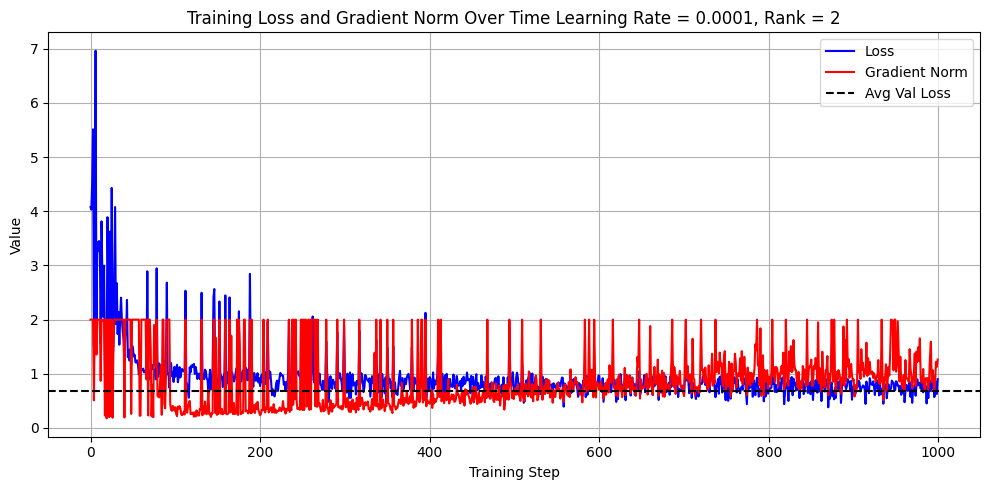


Training with r=4, lr=1e-05


Training Progress Steps 0:   0%|          | 1/1142 [00:00<09:46,  1.94it/s]

[Step 0] Loss: 1.0179 | Grad norm: 0.3506


Validating: 100%|██████████| 75/75 [00:08<00:00,  9.14it/s, avg_loss=0.8280]


-> Train Loss: 0.9193, Perplexity: 2.51
-> Validation Loss: 0.8280, Perplexity: 2.29
-> Estimated Flops: 1196634931200000


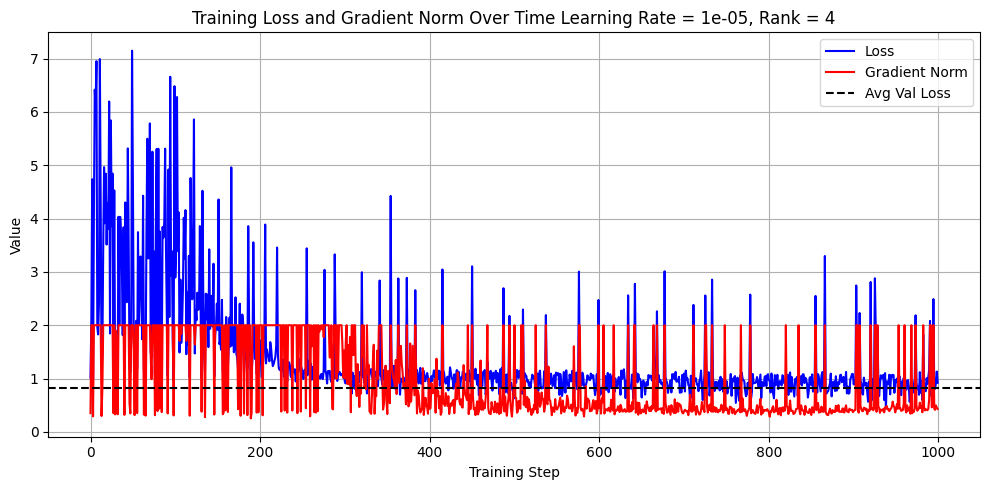


Training with r=4, lr=5e-05


Training Progress Steps 0:   0%|          | 1/1142 [00:00<10:12,  1.86it/s]

[Step 0] Loss: 4.2192 | Grad norm: 2.0000


Validating: 100%|██████████| 75/75 [00:08<00:00,  9.17it/s, avg_loss=0.7007]


-> Train Loss: 0.7736, Perplexity: 2.17
-> Validation Loss: 0.7007, Perplexity: 2.02
-> Estimated Flops: 1196634931200000


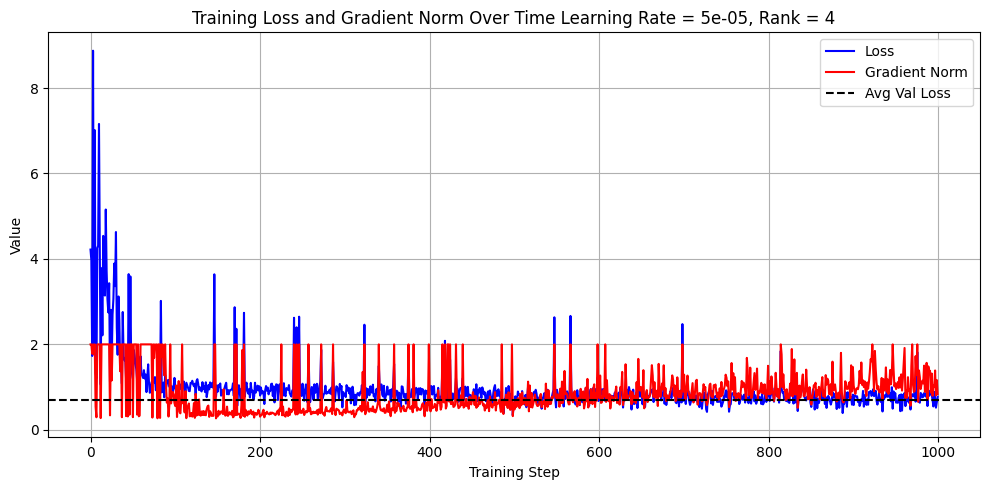


Training with r=4, lr=0.0001


Training Progress Steps 0:   0%|          | 1/1142 [00:00<08:01,  2.37it/s]

[Step 0] Loss: 1.0167 | Grad norm: 0.3110


Validating: 100%|██████████| 75/75 [00:08<00:00,  9.15it/s, avg_loss=0.6669]


-> Train Loss: 0.6115, Perplexity: 1.84
-> Validation Loss: 0.6669, Perplexity: 1.95
-> Estimated Flops: 1196634931200000


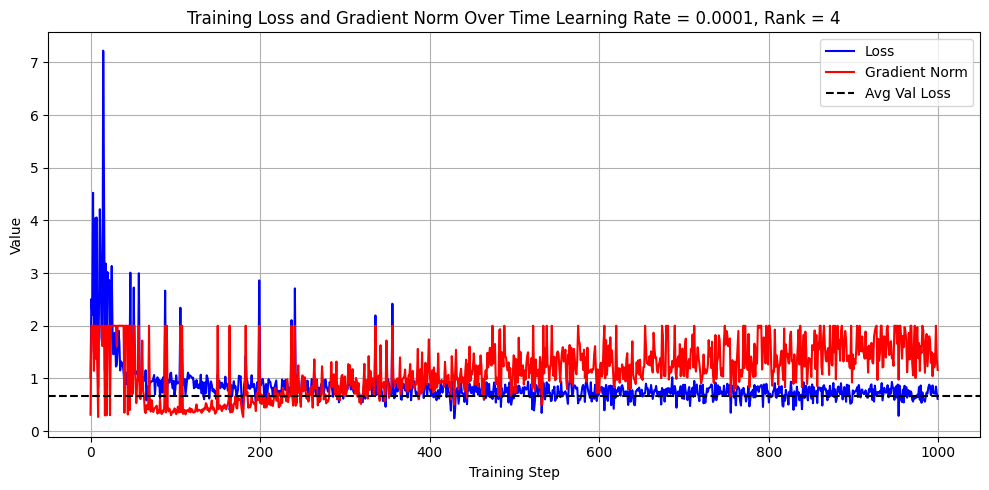


Training with r=8, lr=1e-05


Training Progress Steps 0:   0%|          | 1/1142 [00:00<08:44,  2.17it/s]

[Step 0] Loss: 3.6591 | Grad norm: 2.0000


Validating: 100%|██████████| 75/75 [00:08<00:00,  9.09it/s, avg_loss=0.7837]


-> Train Loss: 0.9214, Perplexity: 2.51
-> Validation Loss: 0.7837, Perplexity: 2.19
-> Estimated Flops: 1198748860416000


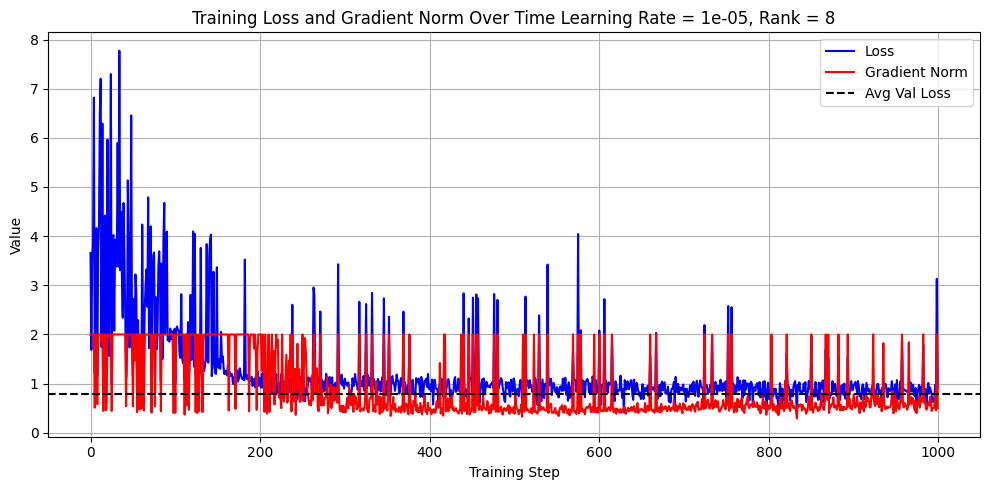


Training with r=8, lr=5e-05


Training Progress Steps 0:   0%|          | 1/1142 [00:00<07:56,  2.39it/s]

[Step 0] Loss: 3.7980 | Grad norm: 2.0000


Validating: 100%|██████████| 75/75 [00:08<00:00,  9.10it/s, avg_loss=0.6760]


-> Train Loss: 0.7804, Perplexity: 2.18
-> Validation Loss: 0.6760, Perplexity: 1.97
-> Estimated Flops: 1198748860416000


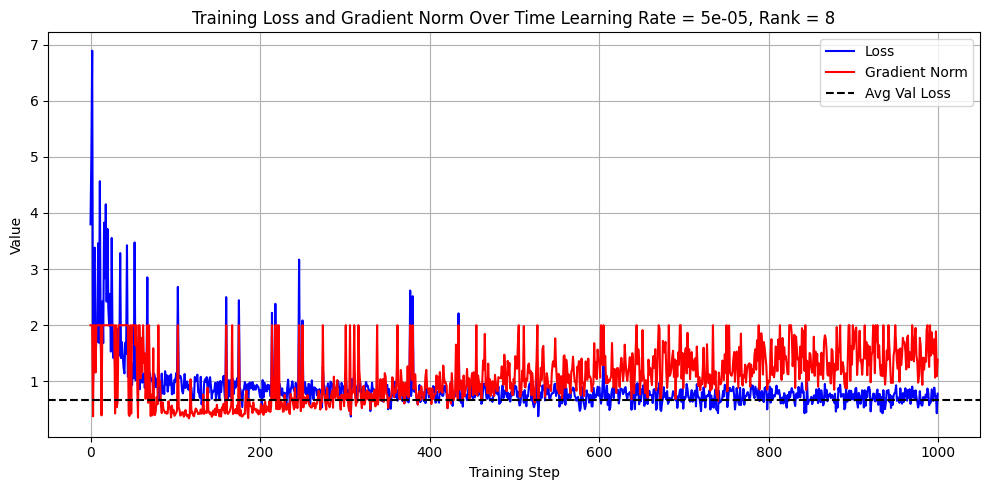


Training with r=8, lr=0.0001


Training Progress Steps 0:   0%|          | 1/1142 [00:00<10:20,  1.84it/s]

[Step 0] Loss: 3.6937 | Grad norm: 2.0000


Validating: 100%|██████████| 75/75 [00:08<00:00,  9.19it/s, avg_loss=0.6545]


-> Train Loss: 0.6684, Perplexity: 1.95
-> Validation Loss: 0.6545, Perplexity: 1.92
-> Estimated Flops: 1198748860416000


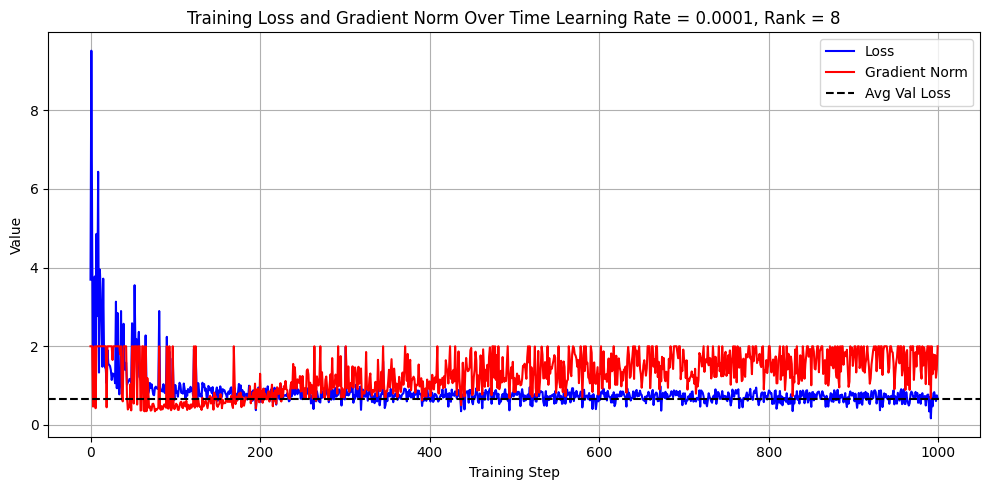

In [4]:

results_rank_lr = []

ranks = [2, 4, 8]
lrs = [1e-5, 5e-5, 1e-4]

for r in ranks:
    for lr in lrs:
        print(f"\nTraining with r={r}, lr={lr}")

        # Load fresh model
        model, _ = load_qwen()

        # Train model and compute loss/perplexity
        trained_model, final_loss, grad_norm_list, train_loss_list = train_lora_model(model, tokenizer, lora_rank=r, learning_rate=lr, train_steps=1000)
        ppl_train = np.exp(final_loss)

        # Compute validation loss and perplexity
        val_loss, _ = evaluate_loss_perplexity_val(trained_model, tokenizer, val_texts, 4)
        ppl_val = np.exp(val_loss)
        
        # Extracting config information to determine estimate number of flops
        config = trained_model.config
        d_model = config.hidden_size
        num_heads = config.num_attention_heads
        num_layers = config.num_hidden_layers
        intermediate_dim = 2 * d_model  # SwiGLU

        # Compute total estimate of flops
        total_flops_estimate = total_transformer_training_flops(1000, 4, 512, num_layers, d_model, num_heads, intermediate_dim, lora_rank=r)

        # Collecting results
        results_rank_lr.append({"rank": r, "learning_rate": lr, "Train Loss": final_loss, "Train Perplexity": ppl_train,
                                "Validation Loss": val_loss, "Validation Perplexity":ppl_val,"Estimated Flops": total_flops_estimate})
        print(f"-> Train Loss: {final_loss:.4f}, Perplexity: {ppl_train:.2f}")
        print(f"-> Validation Loss: {val_loss:.4f}, Perplexity: {ppl_val:.2f}")
        print(f"-> Estimated Flops: {total_flops_estimate}")
        grad_norm_loss_plot(train_loss_list, grad_norm_list, title=f'Learning Rate = {lr}, Rank = {r}', avg_val_loss=val_loss)

        # Clean up to free GPU memory
        del model
        del trained_model
        torch.cuda.empty_cache()
        gc.collect()


In [5]:
# Saving results as a csv file
HP_search_rlr_df = pd.DataFrame(results_rank_lr)
print(HP_search_rlr_df)
HP_search_rlr_df.to_csv("experiment_results/hp_tuning_results/hp_tun_rank_lr.csv")

   rank  learning_rate  Train Loss  Train Perplexity  Validation Loss  \
0     2        0.00001    0.962935          2.619374         0.890286   
1     2        0.00005    0.795186          2.214852         0.726229   
2     2        0.00010    0.901181          2.462510         0.689331   
3     4        0.00001    0.919280          2.507484         0.828003   
4     4        0.00005    0.773604          2.167563         0.700740   
5     4        0.00010    0.611469          1.843137         0.666933   
6     8        0.00001    0.921400          2.512807         0.783735   
7     8        0.00005    0.780378          2.182298         0.675965   
8     8        0.00010    0.668401          1.951116         0.654528   

   Validation Perplexity   Estimated Flops  
0               2.435825  1195577966592000  
1               2.067271  1195577966592000  
2               1.992382  1195577966592000  
3               2.288744  1196634931200000  
4               2.015243  1196634931200000  

After determining best hyper parameters for "rank" and "learning rate", we can procede to determine which of the three context lengths $[128, 512, 768]$ perform the best for a maximun of 2000 RLPPP steps

In [6]:

import torch
# Set seed
torch.manual_seed(23)
torch.cuda.empty_cache() #Clean gpu memory for next experiment


Training with context_lenghts = 128


Training Progress Steps 0:   0%|          | 3/4374 [00:00<11:33,  6.30it/s]

[Step 0] Loss: 4.1172 | Grad norm: 2.0000


Validating: 100%|██████████| 253/253 [00:08<00:00, 31.13it/s, avg_loss=0.9123]


-> Train Loss: 0.9897, Perplexity: 2.69
-> Validation Loss: 0.9123, Perplexity: 2.49
-> Estimated Flops: 297875275776000


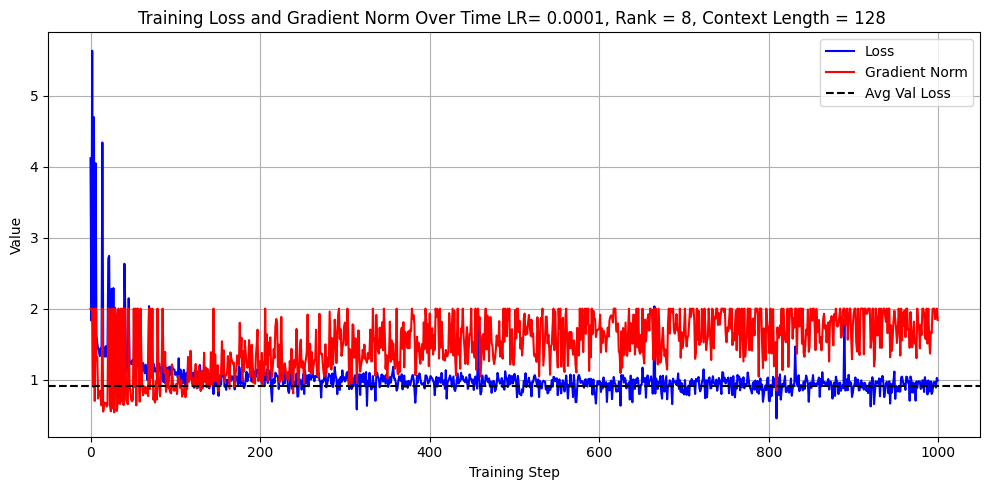


Training with context_lenghts = 512


Training Progress Steps 0:   0%|          | 1/1142 [00:00<09:43,  1.95it/s]

[Step 0] Loss: 1.1661 | Grad norm: 0.5534


Validating: 100%|██████████| 75/75 [00:07<00:00,  9.38it/s, avg_loss=0.6524]

-> Train Loss: 0.8344, Perplexity: 2.30
-> Validation Loss: 0.6524, Perplexity: 1.92
-> Estimated Flops: 1198748860416000


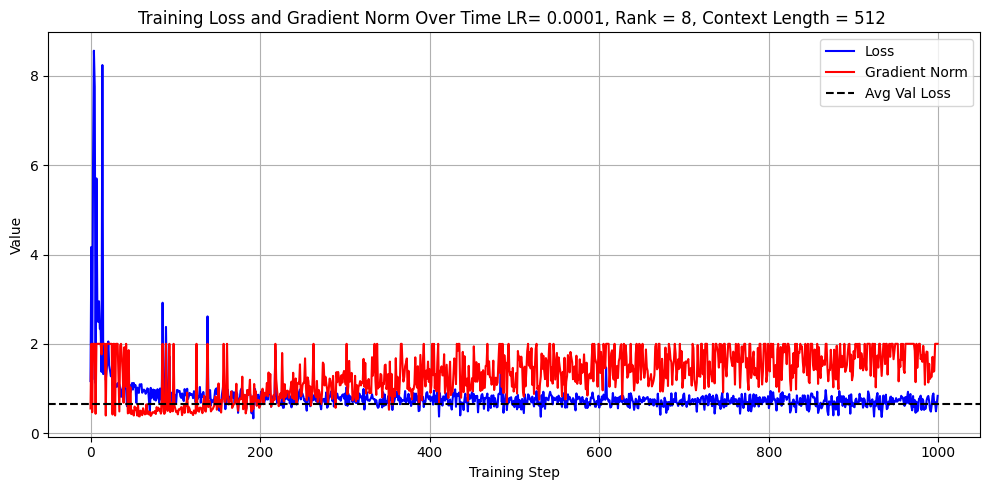


Training with context_lenghts = 768


Training Progress Steps 0:   0%|          | 1/900 [00:01<19:46,  1.32s/it]

[Step 0] Loss: 5.6354 | Grad norm: 2.0000


Training Progress Steps 900:   0%|          | 1/900 [00:00<10:51,  1.38it/s]

[Step 900] Loss: 0.2587 | Grad norm: 0.7422


Validating: 100%|██████████| 50/50 [00:22<00:00,  2.27it/s, avg_loss=0.6339]

-> Train Loss: 0.6043, Perplexity: 1.83
-> Validation Loss: 0.6339, Perplexity: 1.88
-> Estimated Flops: 1805371047936000


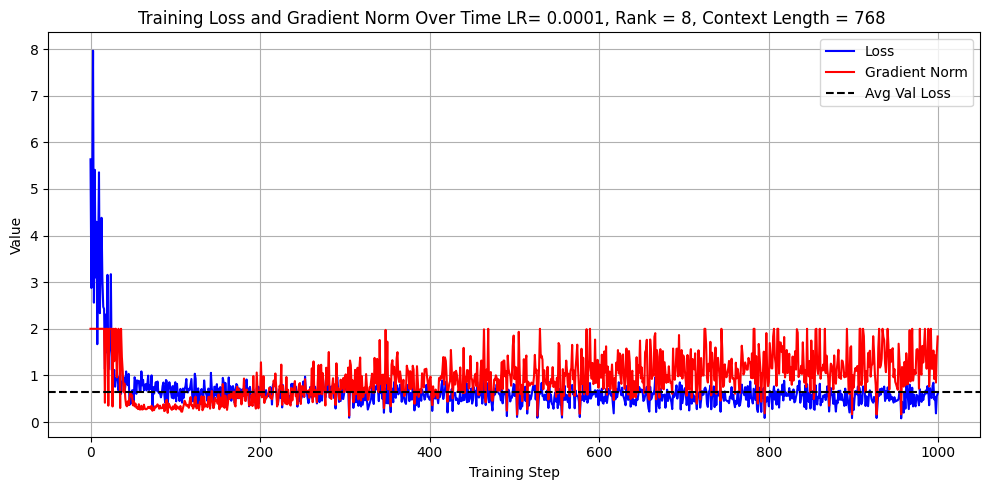

In [4]:

results_cl = []
context_lengths = [128, 512, 768]
best_r = 8
best_lr = 1e-4

for cl in context_lengths:
    print(f"\nTraining with context_lenghts = {cl}")

    # Load fresh model
    model, tokenizer = load_qwen()
    # Train the model and compute loss
    trained_model, final_loss, grad_norm_list, train_loss_list = train_lora_model(model, tokenizer, lora_rank=best_r, learning_rate=best_lr, max_ctx_length=cl, train_steps=1000)
    ppl_train = np.exp(final_loss)


    # Computing validation loss and perplexity
    val_loss, _ = evaluate_loss_perplexity_val(trained_model, tokenizer, val_texts, 4, max_length=cl)
    ppl_val = np.exp(val_loss)
    
    # Extracting config info from the model to estimate flops
    config = trained_model.config
    d_model = config.hidden_size
    num_heads = config.num_attention_heads
    num_layers = config.num_hidden_layers
    intermediate_dim = 2 * d_model  # SwiGLU

    #  Computing total estimate of flops
    total_flops_estimate = total_transformer_training_flops(1000, 4, cl, num_layers, d_model, num_heads, intermediate_dim, lora_rank=best_r)

    # Collecting results
    results_cl.append({"context_lengths": cl, "Train Loss": final_loss, "Train Perplexity": ppl_train,
                       "Validation Loss": val_loss, "Validation Perplexity": ppl_val,"Estimated Flops": total_flops_estimate})
    
    # Print results at each stage
    print(f"-> Train Loss: {final_loss:.4f}, Perplexity: {ppl_train:.2f}")
    print(f"-> Validation Loss: {val_loss:.4f}, Perplexity: {ppl_val:.2f}")
    print(f"-> Estimated Flops: {total_flops_estimate}")

    grad_norm_loss_plot(train_loss_list, grad_norm_list, title=f'LR= {best_lr}, Rank = {best_r}, Context Length = {cl} ', avg_val_loss=val_loss)

    # Clean up to free GPU memory
    del model
    del trained_model
    torch.cuda.empty_cache()
    gc.collect()


In [5]:
# Saving results as a csv file
HP_search_cl_df = pd.DataFrame(results_cl)
print(HP_search_cl_df)

HP_search_cl_df.to_csv("experiment_results/hp_tuning_results/hp_tun_cl.csv")

   context_lengths  Train Loss  Train Perplexity  Validation Loss  \
0              128    0.989703          2.690435         0.912295   
1              512    0.834394          2.303417         0.652382   
2              768    0.604336          1.830036         0.633898   

   Validation Perplexity   Estimated Flops  
0               2.490031   297875275776000  
1               1.920110  1198748860416000  
2               1.884943  1805371047936000  


# Part 3 (c)

In this section we will pefrom full training and validation using the best hyper-parameters determined in the previus section, determine the number of flops and all the metrics just like in previus parts, and compare resuts of the tuned model to the trained but not tuned Qwen2.5 with LoRA.

In [1]:
import torch
# Set seed
torch.manual_seed(23)
torch.cuda.empty_cache() #Clean gpu memory for next experiment

In [2]:
# Follecting from previus results

r_opt = 8 # Optimal Rank
lr_opt = 1e-4 # optimal Learning Rate
cl_opt = 768 # Optimal Context Length

Training Model with the above parameters (and determine loss/perplexity)

In [3]:
from src.qwen import load_qwen
model_opt, tokenizer = load_qwen() # Loading Qwen2.5

/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [4]:
from src.set_up_lora import*
model_opt_train1, loss_train1, grad_norm_values1, loss_values1 = train_lora_model(model_opt, tokenizer, lora_rank=r_opt, learning_rate=lr_opt, batch_size=4, max_ctx_length=cl_opt,train_steps=5000) # Training model

Training Progress Steps 0:   0%|          | 1/900 [00:00<12:44,  1.18it/s]

[Step 0] Loss: 8.5948 | Grad norm: 2.0000


Training Progress Steps 900:   0%|          | 1/900 [00:00<10:27,  1.43it/s]

[Step 900] Loss: 0.2546 | Grad norm: 0.6437


Training Progress Steps 1800:   0%|          | 1/900 [00:00<10:12,  1.47it/s]

[Step 1800] Loss: 0.4002 | Grad norm: 2.0000


Training Progress Steps 2700:   0%|          | 1/900 [00:00<10:48,  1.39it/s]

[Step 2700] Loss: 0.6853 | Grad norm: 2.0000


Training Progress Steps 3600:   0%|          | 1/900 [00:00<10:33,  1.42it/s]

[Step 3600] Loss: 0.3549 | Grad norm: 1.3627


Training Progress Steps 4500:   0%|          | 1/900 [00:00<10:28,  1.43it/s]

[Step 4500] Loss: 0.4560 | Grad norm: 2.0000


Training Progress Steps 4500:  55%|█████▌    | 499/900 [05:28<04:24,  1.52it/s]


Collecting train and validation loss/perplexity and FLOPs

In [6]:
from src.flops import*

# Computing validation loss and perplexity

_, val_texts, _ = load_and_preprocess("data/lotka_volterra_data.h5") # Reloading validation set

ppl_best_train = np.exp(loss_train1) # Perplexity on trained model

# Validation loss and perplexity of best model
loss_best_val, ppl_best_val = evaluate_loss_perplexity_val(model_opt_train1, tokenizer, val_texts, 4,  max_length=cl_opt)

# Extracting config info from the model to estimate flops
config = model_opt_train1.config
d_model = config.hidden_size
num_heads = config.num_attention_heads
num_layers = config.num_hidden_layers
intermediate_dim = 2*d_model  # SwiGLU

#  Computing total estimate of flops
total_flops_for_best_model = total_transformer_training_flops(5000, 4, cl_opt, num_layers, d_model, num_heads, intermediate_dim, lora_rank=r_opt)

# collecting results
collecting_results = [[loss_train1, ppl_best_train, 
                       loss_best_val, ppl_best_val,
                      total_flops_for_best_model]
                      ]
columns = ["Training Loss", "Training Perplexity", "Validation Loss", "Validation Perplexity", "FLOPs"]

# Collecting results in pd.DataFrame

best_model_results_df = pd.DataFrame(collecting_results, columns=columns)
print("Metric results from best model:")
print("")
print(best_model_results_df)

# Save results

best_model_results_df.to_csv("experiment_results/best_model_results/best_model_trval_loss_ppl.csv")

Validating: 100%|██████████| 50/50 [00:22<00:00,  2.26it/s, avg_loss=0.5615]

Metric results from best model:

   Training Loss  Training Perplexity  Validation Loss  Validation Perplexity  \
0       0.387473             1.473253         0.561467               1.753243   

              FLOPs  
0  9026855239680000  


Using best model for predictions

In [7]:
# Prediction after training
_,_,val_texts_70 = load_and_preprocess("data/lotka_volterra_data.h5") # Reload 70% of validation set

# Compute prediction
predicted_encoded1 = prediction_after_training(model_opt_train1, tokenizer, val_texts_70)

Generating predictions:   0%|          | 0/100 [00:00<?, ?it/s]/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=T

Determining metrics from predictions, MSE, RMSE and error in each system

In [8]:
predictions_decoded1, predicted_output1, true_values1, MSE_values1, RMSE_values1, error_per_system1 = decoder_and_metrics_evaluator(predicted_encoded1, tokenizer)

Saving metrics

In [9]:
np.savez("experiment_results/best_model_results/predictions_decoded_best.npz", *predictions_decoded1)
MSE_loaded = np.save("experiment_results/best_model_results/MSE_values_best.npy", np.array(MSE_values1))
np.save('experiment_results/best_model_results/RMSE_values_best', RMSE_values1)
np.savez("experiment_results/best_model_results/error_per_system_best.npz", *error_per_system1)

### Visualisation

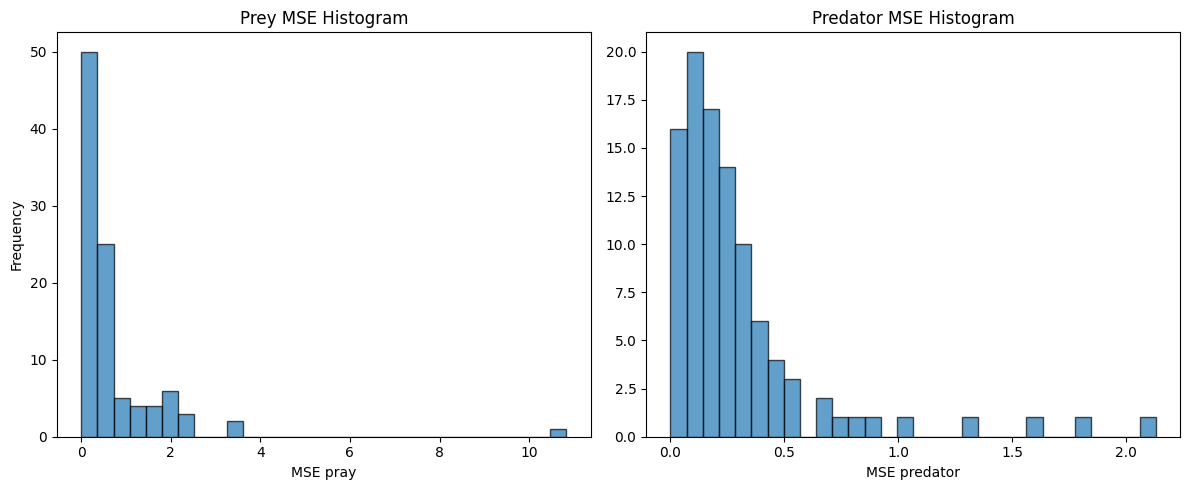

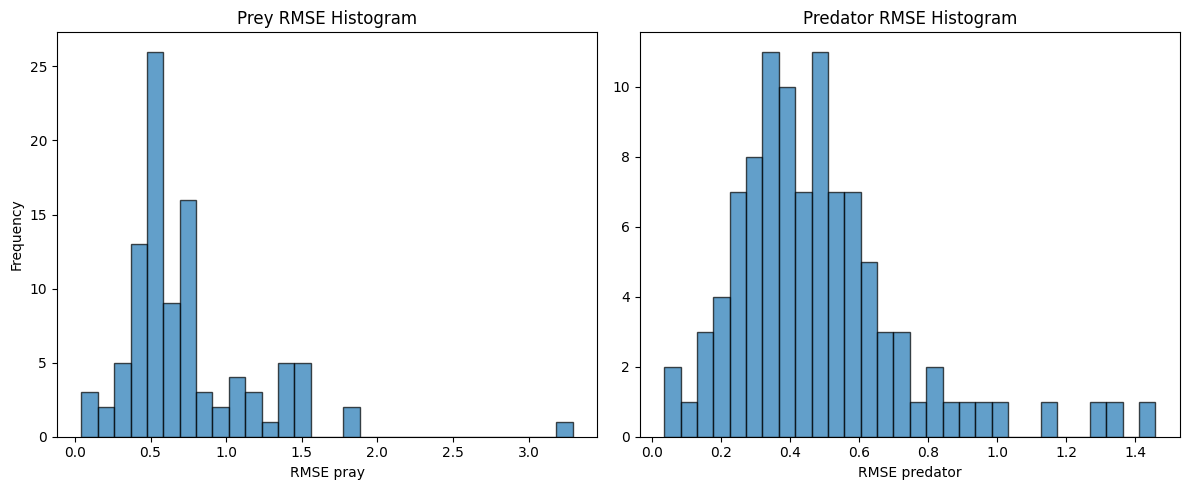

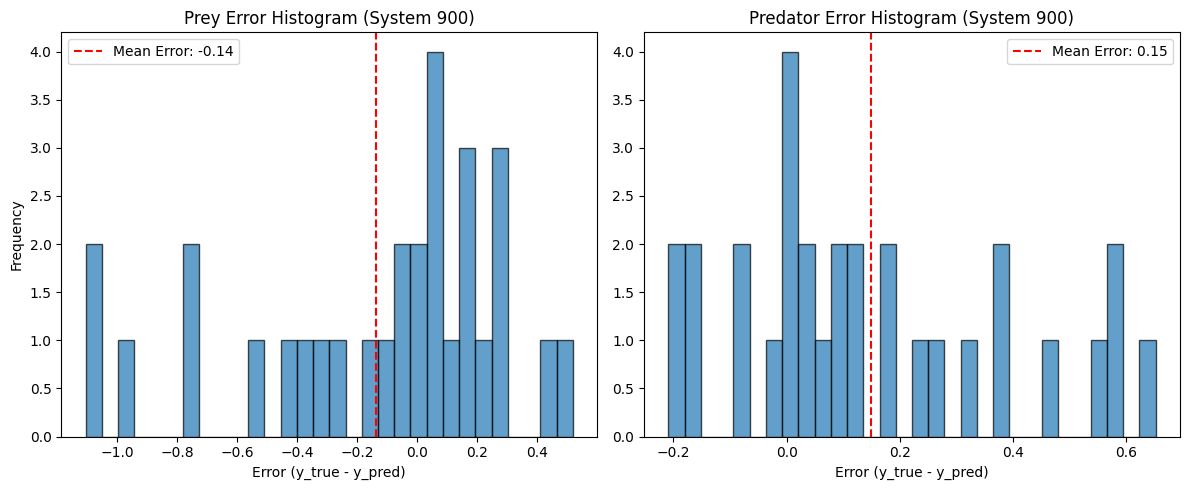

Decoded prediction shape: (103, 2)
True dataset shape: (30, 2)


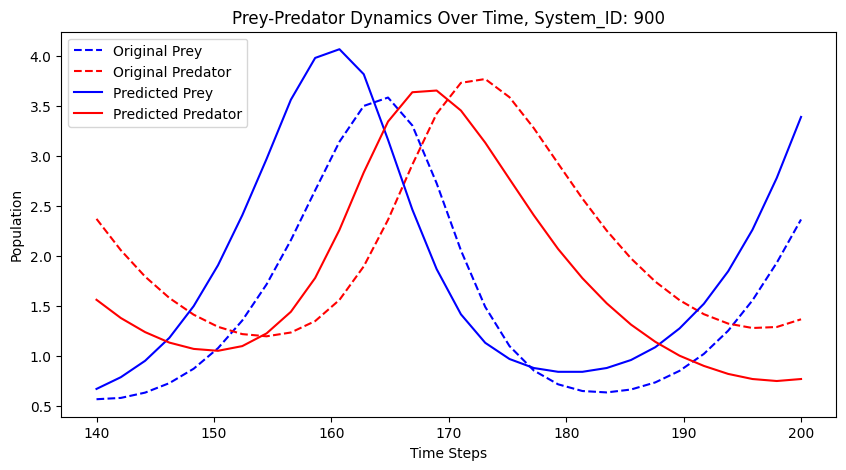

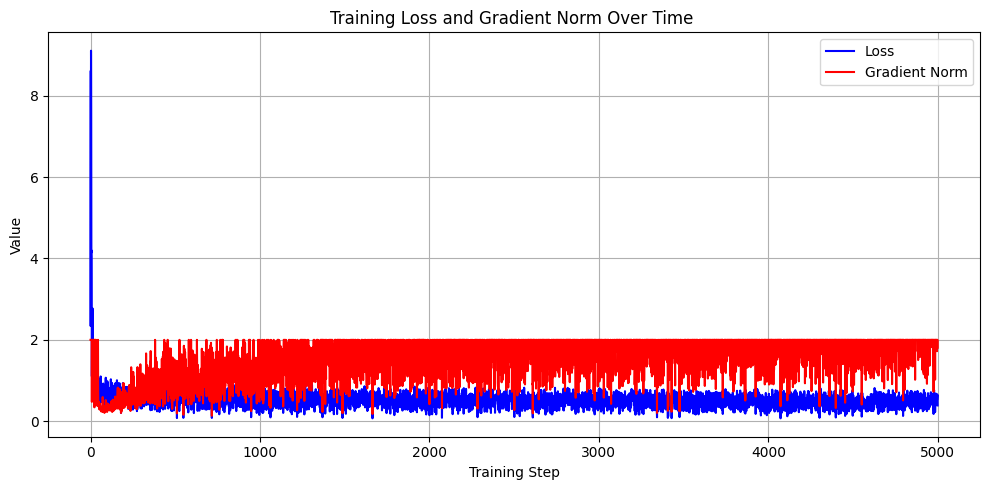

In [10]:
collective_plots(predicted_encoded1, tokenizer)
grad_norm_loss_plot(loss_values1, grad_norm_values1) # printing loss and grad norm over training steps

# 5000 Steps Experiment Repeated With Different HP Choice

In [1]:
import numpy as np
import torch
import torch.nn as nn
from src.set_up_lora import*
from src.preprocessor import*
from src.flops import*
import gc
import torch
from src.qwen import load_qwen
from src.set_up_lora import*
_, val_texts, _ = load_and_preprocess("data/lotka_volterra_data.h5")
import pandas as pd

/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [2]:

# Set seed
torch.manual_seed(23)
torch.cuda.empty_cache() #Clean gpu memory for next experiment

In [3]:
# Follecting from previus results

r_opt = 8 # Optimal Rank
lr_opt = 1e-5 # optimal Learning Rate
cl_opt = 512 # Optimal Context Length


In [4]:
model_opt, tokenizer = load_qwen() # Loading Qwen2.5

In [5]:
model_opt_train2, loss_train2, grad_norm_values2, loss_values2 = train_lora_model(model_opt, tokenizer, lora_rank=r_opt, learning_rate=lr_opt, batch_size=4, max_ctx_length=cl_opt,train_steps=5000) # Training model

Training Progress Steps 0:   0%|          | 1/1142 [00:00<12:21,  1.54it/s]

[Step 0] Loss: 1.2233 | Grad norm: 0.3945


Training Progress Steps 1142:   0%|          | 1/1142 [00:00<04:43,  4.03it/s]

[Step 1142] Loss: 0.8150 | Grad norm: 0.5600


Training Progress Steps 2284:   0%|          | 1/1142 [00:00<04:44,  4.02it/s]

[Step 2284] Loss: 0.9184 | Grad norm: 1.0124


Training Progress Steps 3426:   0%|          | 1/1142 [00:00<04:43,  4.03it/s]

[Step 3426] Loss: 0.5095 | Grad norm: 0.8443


Training Progress Steps 4568:   0%|          | 1/1142 [00:00<04:45,  4.00it/s]

[Step 4568] Loss: 0.6918 | Grad norm: 1.3045


Training Progress Steps 4568:  38%|███▊      | 431/1142 [01:38<02:42,  4.36it/s]


In [7]:
# Computing validation loss and perplexity

_, val_texts, _ = load_and_preprocess("data/lotka_volterra_data.h5") # Reloading validation set

ppl_best_train = np.exp(loss_train2) # Perplexity on trained model

# Validation loss and perplexity of best model
loss_best_val, ppl_best_val = evaluate_loss_perplexity_val(model_opt_train2, tokenizer, val_texts, 4,  max_length=cl_opt)

# Extracting config info from the model to estimate flops
config = model_opt_train2.config
d_model = config.hidden_size
num_heads = config.num_attention_heads
num_layers = config.num_hidden_layers
intermediate_dim = 2*d_model  # SwiGLU

#  Computing total estimate of flops
total_flops_for_best_model = total_transformer_training_flops(5000, 4, cl_opt, num_layers, d_model, num_heads, intermediate_dim, lora_rank=r_opt)

# collecting results
collecting_results = [[loss_train2, ppl_best_train, 
                       loss_best_val, ppl_best_val,
                      total_flops_for_best_model]
                      ]
columns = ["Training Loss", "Training Perplexity", "Validation Loss", "Validation Perplexity", "FLOPs"]

# Collecting results in pd.DataFrame

best_model_results_df = pd.DataFrame(collecting_results, columns=columns)
print("Metric results from best model:")
print("")
print(best_model_results_df)

# Save results

best_model_results_df.to_csv("experiment_results/tuned_lora_3c_hp_5000/best_model_trval_loss_ppl.csv")

Validating: 100%|██████████| 75/75 [00:05<00:00, 12.58it/s, avg_loss=0.6703]  

Metric results from best model:

   Training Loss  Training Perplexity  Validation Loss  Validation Perplexity  \
0       0.656826              1.92866         0.670274               1.954773   

              FLOPs  
0  5993744302080000  


In [8]:
# Prediction after training
_,_,val_texts_70 = load_and_preprocess("data/lotka_volterra_data.h5") # Reload 70% of validation set

# Compute prediction
predicted_encoded2 = prediction_after_training(model_opt_train2, tokenizer, val_texts_70)

Generating predictions:   0%|          | 0/100 [00:00<?, ?it/s]/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/riccardo_mancini/M2_Cw/m2_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=T

In [9]:
predictions_decoded2, predicted_output2, true_values2, MSE_values2, RMSE_values2, error_per_system2 = decoder_and_metrics_evaluator(predicted_encoded2, tokenizer)

In [10]:
np.savez("experiment_results/tuned_lora_3c_hp_5000/predictions_decoded_best.npz", *predictions_decoded2)
MSE_loaded = np.save("experiment_results/tuned_lora_3c_hp_5000/MSE_values_best.npy", np.array(MSE_values2))
np.save('experiment_results/tuned_lora_3c_hp_5000/RMSE_values_best', RMSE_values2)
np.savez("experiment_results/tuned_lora_3c_hp_5000/error_per_system_best.npz", *error_per_system2)

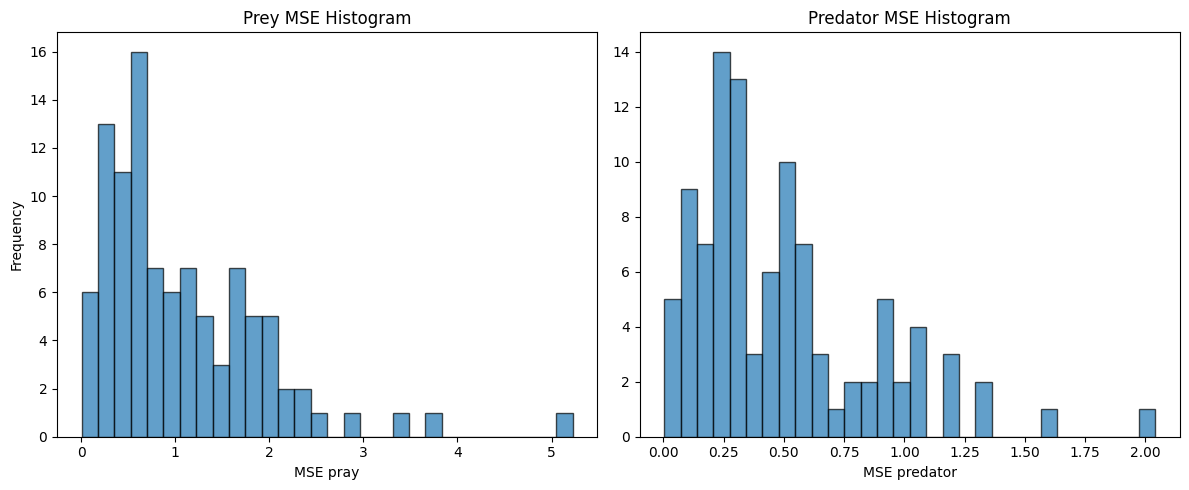

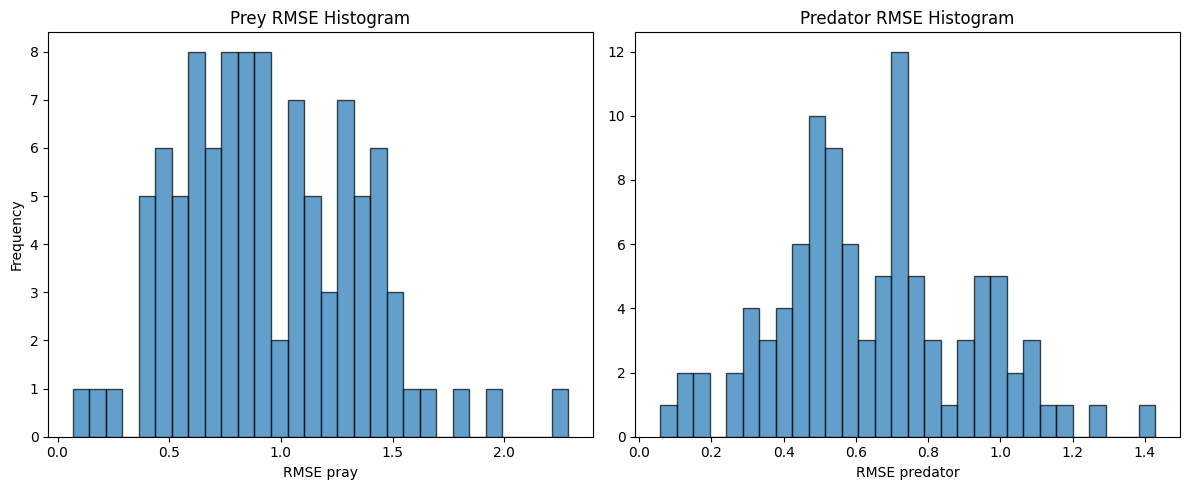

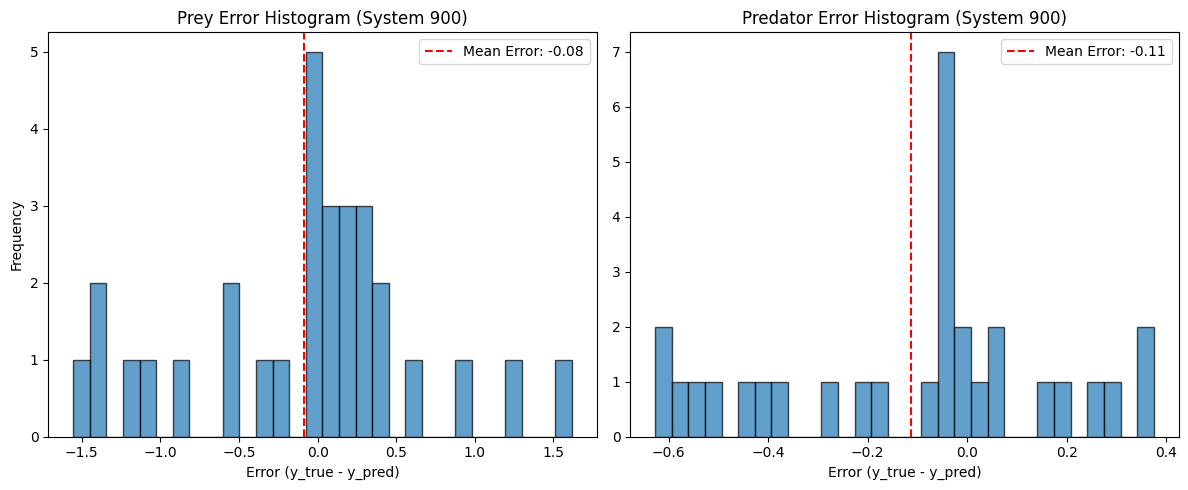

Decoded prediction shape: (103, 2)
True dataset shape: (30, 2)


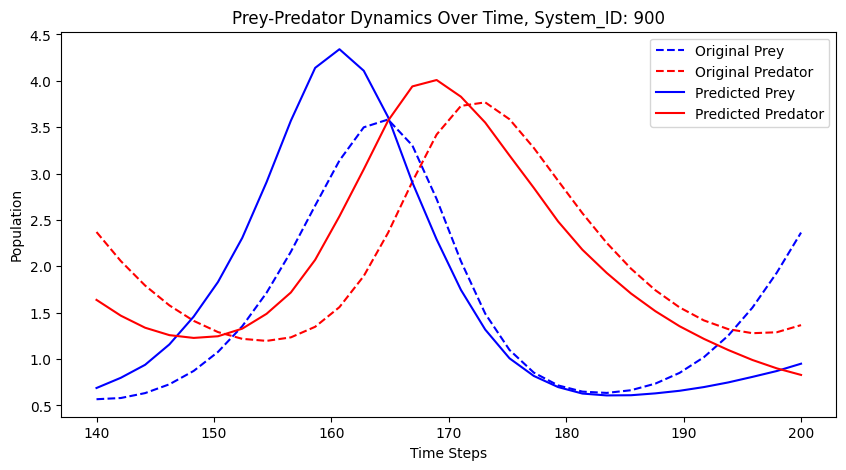

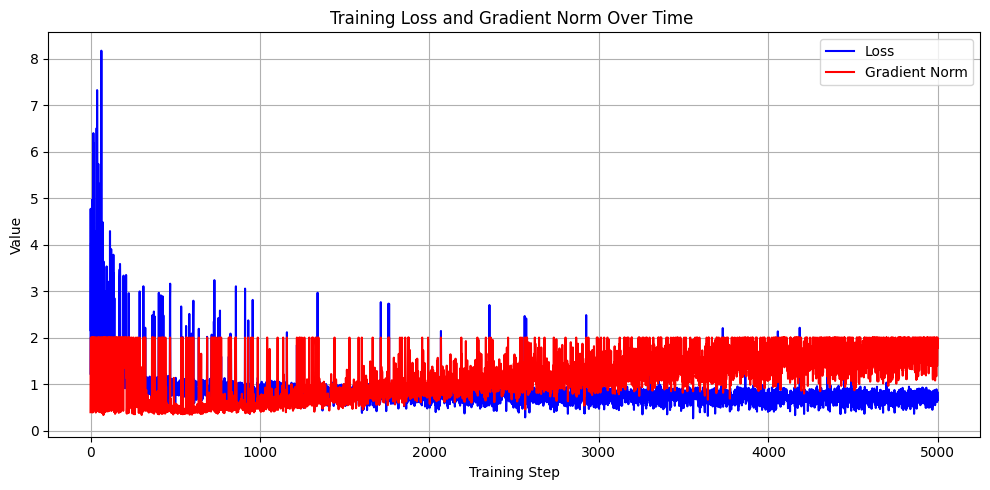

In [11]:
collective_plots(predicted_encoded2, tokenizer)
grad_norm_loss_plot(loss_values2, grad_norm_values2) # printing loss and grad norm over training steps

# Determine Model Perfoemance Based on Metrics Comparison Summary

We have trained 3 models, each with 5000 steps, now we want to determine which model prediction forecasing works the best?

1. Model 1, fine-tuning Qwen2.5-0.5B with LoRA layers, rank = 4, learning rate = 1e-5, and context length = 512 (default settings)
2. Model 2, HP tuning of Qwen2.5-0.5B with LoRA layers, rank = 8, learning rate = 0.0001, and context length = 768
3. Model 3, HP tuning of Qwen2.5-0.5B with LoRA layers, rank = 8, learning rate = 0.0001, and context length = 512
4. Model 4, untrained Qwen + LoRA
5. Model 5, untrained Qwen

### Metric Results

In [37]:
import numpy as np
# trained models
MSE1 = np.load("experiment_results/trained_lora_3a_5000/MSE_values_3a.npy")
MSE2 = np.load("experiment_results/best_model_results/MSE_values_best.npy")
MSE3 = np.load("experiment_results/tuned_lora_3c_hp_5000/MSE_values_best.npy")

# untrained models
MSE4 = np.load("experiment_results/untrained_qwen_plus_lora_results/MSE_values_3a.npy")
MSE5 = np.load("experiment_results/untrained_qwen_results/MSE_values_2b.npy")


In [39]:
# Model 1

prey_mse_avg1 = np.average(MSE1[:,0]) # MSE average prey
predator_mse_avg1 = np.average(MSE1[:,1]) # MSE average predator
model1_mse_avg = np.average(MSE1) # Overall MSE average 

# Model 2

prey_mse_avg2 = np.average(MSE2[:,0]) # MSE average prey
predator_mse_avg2 = np.average(MSE2[:,1]) # MSE average predator
model2_mse_avg = np.average(MSE2) # Overall MSE average 

# Model 3

prey_mse_avg3 = np.average(MSE3[:,0]) # MSE average prey
predator_mse_avg3 = np.average(MSE3[:,1]) # MSE average predator
model3_mse_avg = np.average(MSE3) # Overall MSE average 

# Model 4 

prey_mse_avg4 = np.average(MSE4[:,0]) # MSE average prey
predator_mse_avg4 = np.average(MSE4[:,1]) # MSE average predator
model4_mse_avg = np.average(MSE4) # Overall MSE average

# Model 5

prey_mse_avg5 = np.average(MSE5[:,0]) # MSE average prey
predator_mse_avg5 = np.average(MSE5[:,1]) # MSE average predator
model5_mse_avg = np.average(MSE5) # Overall MSE average

In [41]:
print('Trained Models:')
print(f'Average MSE values for model 1: {model1_mse_avg:.4f}, prey average MSE: {prey_mse_avg1:.4f}, predator average MSE: {predator_mse_avg1:.4f} (fine-tuning Qwen2.5-0.5B + LoRA)')
print(f'Average MSE values for model 2: {model2_mse_avg:.4f}, prey average MSE: {prey_mse_avg2:.4f}, predator average MSE: {predator_mse_avg2:.4f} (Tuned Model r=8, lr=1e-4, cl=768)')
print(f'Average MSE values for model 3: {model3_mse_avg:.4f}, prey average MSE: {prey_mse_avg3:.4f}, predator average MSE: {predator_mse_avg3:.4f} (Tuned Model r=8, lr=1e-4, cl=512)')
print('')
print('Untrained Models:')
print(f'Average MSE values for model 4: {model4_mse_avg:.4f}, prey average MSE: {prey_mse_avg4:.4f}, predator average MSE: {predator_mse_avg4:.4f} (Qwen2.5-0.5B + LoRA Untrained)')
print(f'Average MSE values for model 5: {model5_mse_avg:.4f}, prey average MSE: {prey_mse_avg5:.4f}, predator average MSE: {predator_mse_avg5:.4f} (Qwen2.5-0.5B Untrained)')

Trained Models:
Average MSE values for model 1: 0.8332, prey average MSE: 1.1271, predator average MSE: 0.5393 (fine-tuning Qwen2.5-0.5B + LoRA)
Average MSE values for model 2: 0.5290, prey average MSE: 0.7613, predator average MSE: 0.2966 (Tuned Model r=8, lr=1e-4, cl=768)
Average MSE values for model 3: 0.7742, prey average MSE: 1.0555, predator average MSE: 0.4928 (Tuned Model r=8, lr=1e-4, cl=512)

Untrained Models:
Average MSE values for model 4: 6.5425, prey average MSE: 5.7826, predator average MSE: 7.3024 (Qwen2.5-0.5B + LoRA Untrained)
Average MSE values for model 5: 4.0419, prey average MSE: 3.2790, predator average MSE: 4.8049 (Qwen2.5-0.5B Untrained)


# Total Number of FLOPs

In [3]:
initial_budget = 10**17

# Training procedure no tuning
FLOPs_train_no_hp_tuned = 5983174656000000

# HP search total FLOPs

# Rank + Learning-Rate
search_1 = 1195577966592000*3 # This number of FLOPs has occurred 3 times
search_2 = 1196634931200000*3 # This number of FLOPs has occurred 3 times
search_3 = 1198748860416000*3 # This number of FLOPs has occurred 3 times

# Context Length
search_clx_1 = 297875275776000
search_clx_2 = 1198748860416000
search_clx_3 = 1805371047936000

# Total FLOPs hp search

Total_FLOPS_hp_search = search_1 + search_2 + search_3 + search_clx_1 + search_clx_2 + search_clx_3

# Training experiment 1 hp optimal
FLOPs_train_hp_tuned_1 = 9026855239680000

# Training experiment 2 hp optimal
FLOPs_train_hp_tuned_2 = 5993744302080000  

remaining_FLOPs_budget = initial_budget - (FLOPs_train_no_hp_tuned + Total_FLOPS_hp_search + FLOPs_train_hp_tuned_1 + FLOPs_train_hp_tuned_2) 

print('Remaining FLOPs budget:', remaining_FLOPs_budget)


Remaining FLOPs budget: 64921345343488000
